#Raytracer

Let's code a photorealistic 3D renderer.

### Imports

In [ ]:
from PIL import Image
from functools import reduce
import numpy as np
import time
import numbers

### Classes

####_Vector Class_

In [ ]:
class Vec3(object):
  def __init__(self, x, y, z):
    (self.x, self.y, self.z) = (x, y, z)
  def __mul__(self, other):
    return Vec3(self.x * other, self.y * other, self.z * other)
  def multiply(self, other):
    return Vec3(self.x * other, self.y * other, self.z * other)
  def __add__(self, other):
    return Vec3(self.x + other.x, self.y + other.y, self.z + other.z)
  def __sub__(self, other):
    return Vec3(self.x - other.x, self.y - other.y, self.z - other.z)
  def dot(self, other):
    return (self.x * other.x) + (self.y * other.y) + (self.z * other.z)
  def __abs__(self):
    return self.dot(self)
  def norm(self):
    mag = np.sqrt(abs(self))
    return self * (1.0 / np.where(mag == 0, 1, mag))
  def components(self):
    return (self.x, self.y, self.z)
  def extract(self, cond):
    return Vec3(extract(cond, self.x),
                extract(cond, self.y),
                extract(cond, self.z)
                )
  def place(self, cond):
    r = Vec3(np.zeros(cond.shape), np.zeros(cond.shape), np.zeros(cond.shape))
    np.place(r.x, cond, self.x)
    np.place(r.y, cond, self.y)
    np.place(r.z, cond, self.z)
    return r

####_Sphere Class_

In [ ]:
class Sphere(object):
  def __init__(self, center, r, diffuse, mirror=0.5):
    self.c = center
    self.r = r
    self.diffuse = diffuse
    self.mirror = mirror

  def intersect(self, O, D):
    b = 2 * D.dot(O - self.c)
    c = abs(self.c) + abs(O) - 2 * self.c.dot(O) - self.r * self.r
    disc = (b**2) - (4 * c)
    sq = np.sqrt(np.maximum(0, disc))
    h0 = (-b - sq) / 2
    h1 = (-b + sq) / 2
    h = np.where((h0 > 0) & (h0 < h1), h0, h1)
    pred = (disc > 0) & (h > 0)
    return np.where(pred, h, FARAWAY)

  def diffusecolor(self, M):
    return self.diffuse

  def light(self, O, D, d, scene, bounce):
    M = (O + D * d)
    N = (M - self.c) *  (1 / self.r)
    toL = (L - M).norm()
    toO = (E - M).norm()
    nudged = M + N * .0001

    light_distances = [s.intersect(nudged, toL) for s in scene]
    light_nearest =  reduce(np.minimum, light_distances)
    seelight = light_distances[scene.index(self)] == light_nearest

    color = rgb(0.25, 0.25, 0.25)

    lv = np.maximum(N.dot(toL), 0)
    color = self.diffusecolor(M) * lv * seelight

    if bounce < 2:
      rayD = (D - N * 2 * D.dot(N)).norm()
      color += raytrace(nudged, rayD, scene, bounce + 1) * self.mirror

    phong = N.dot((toL + toO).norm())
    color += rgb(1, 1, 1) * np.power(np.clip(phong, 0, 1), 50) * seelight
    return color

####_Checkered Sphere Class_

In [ ]:
class CheckeredSphere(object):
  def __init__(self, center, r, diffuse, mirror=0.5):
    self.c = center
    self.r = r
    self.diffuse = diffuse
    self.mirror = mirror

  def intersect(self, O, D):
    b = 2 * D.dot(O - self.c)
    c = abs(self.c) + abs(O) - 2 * self.c.dot(O) - self.r * self.r
    disc = (b**2) - (4 * c)
    sq = np.sqrt(np.maximum(0, disc))
    h0 = (-b - sq) / 2
    h1 = (-b + sq) / 2
    h = np.where((h0 > 0) & (h0 < h1), h0, h1)
    pred = (disc > 0) & (h > 0)
    return np.where(pred, h, FARAWAY)

  def diffusecolor(self, M):
    checker = ((M.x * 2).astype(int) % 2) == ((M.z * 2).astype(int) % 2)
    return self.diffuse * checker



  def light(self, O, D, d, scene, bounce):
    M = (O + D * d)
    N = (M - self.c) *  (1 / self.r)
    toL = (L - M).norm()
    toO = (E - M).norm()
    nudged = M + N * .0001

    light_distances = [s.intersect(nudged, toL) for s in scene]
    light_nearest =  reduce(np.minimum, light_distances)
    seelight = light_distances[scene.index(self)] == light_nearest

    color = rgb(0.25, 0.25, 0.25)

    lv = np.maximum(N.dot(toL), 0)
    color = self.diffusecolor(M) * lv * seelight

    if bounce < 2:
      rayD = (D - N * 2 * D.dot(N)).norm()
      color += raytrace(nudged, rayD, scene, bounce + 1) * self.mirror

    phong = N.dot((toL + toO).norm())
    color += rgb(1, 1, 1) * np.power(np.clip(phong, 0, 1), 50) * seelight
    return color

### Functions

In [ ]:
def extract(cond, x):
  if isinstance(x, numbers.Number):
    return x
  else:
    return np.extract(cond, x)

In [ ]:
def raytrace(O, D, scene, bounce=0):
  distances = [s.intersect(O, D) for s in scene]
  nearest = reduce(np.minimum, distances)
  color = rgb(0, 0, 0)
  for (s, d) in zip(scene, distances):
    hit = (nearest != FARAWAY ) & (d == nearest)
    if np.any(hit):
      dc = extract(hit, d)
      Oc = O.extract(hit)
      Dc = D.extract(hit)
      cc = s.light(Oc, Dc, dc, scene, bounce)
      color += cc.place(hit)
  return color

### Initialize Variables

In [ ]:
rgb = Vec3
(w, h) = (1920, 1080)
L = Vec3(5, 5, -10)
E = Vec3(0, 0.35, -1)
FARAWAY = 1.0e39

### Scene Description

In [ ]:
scene = [
  Sphere(Vec3(.75, .1,  1), .3, rgb(1, 0, 0), .2),
  Sphere(Vec3(1, .5, 1), .3, rgb(0, 0, 1), .9),
  CheckeredSphere(Vec3(0, -99999.5, 0), 99999, rgb(1, 1, 1), 0)
]

### Calculations

In [ ]:
r = float(w) / h
S = (-1, 1 / r + .25, 1, -1 / r +.25)
x = np.tile(np.linspace(S[0], S[2], w), h)
y = np.repeat(np.linspace(S[1], S[3], h), w)

### Raytrace (with render time)

In [ ]:
t0 = time.time()
Q = Vec3(x, y, 0)
color = raytrace(E, (Q - E).norm(), scene)
print("Took", time.time() - t0)

Took 1.1834380626678467


### Save image to file

In [ ]:
file_name = "rendered_scene.png"
rgb1 = [Image.fromarray((255 * np.clip(c, 0, 1).reshape((h, w))).astype(np.uint8), "L") for c in color.components()]
Image.merge("RGB", rgb1).save(file_name)

### Display image

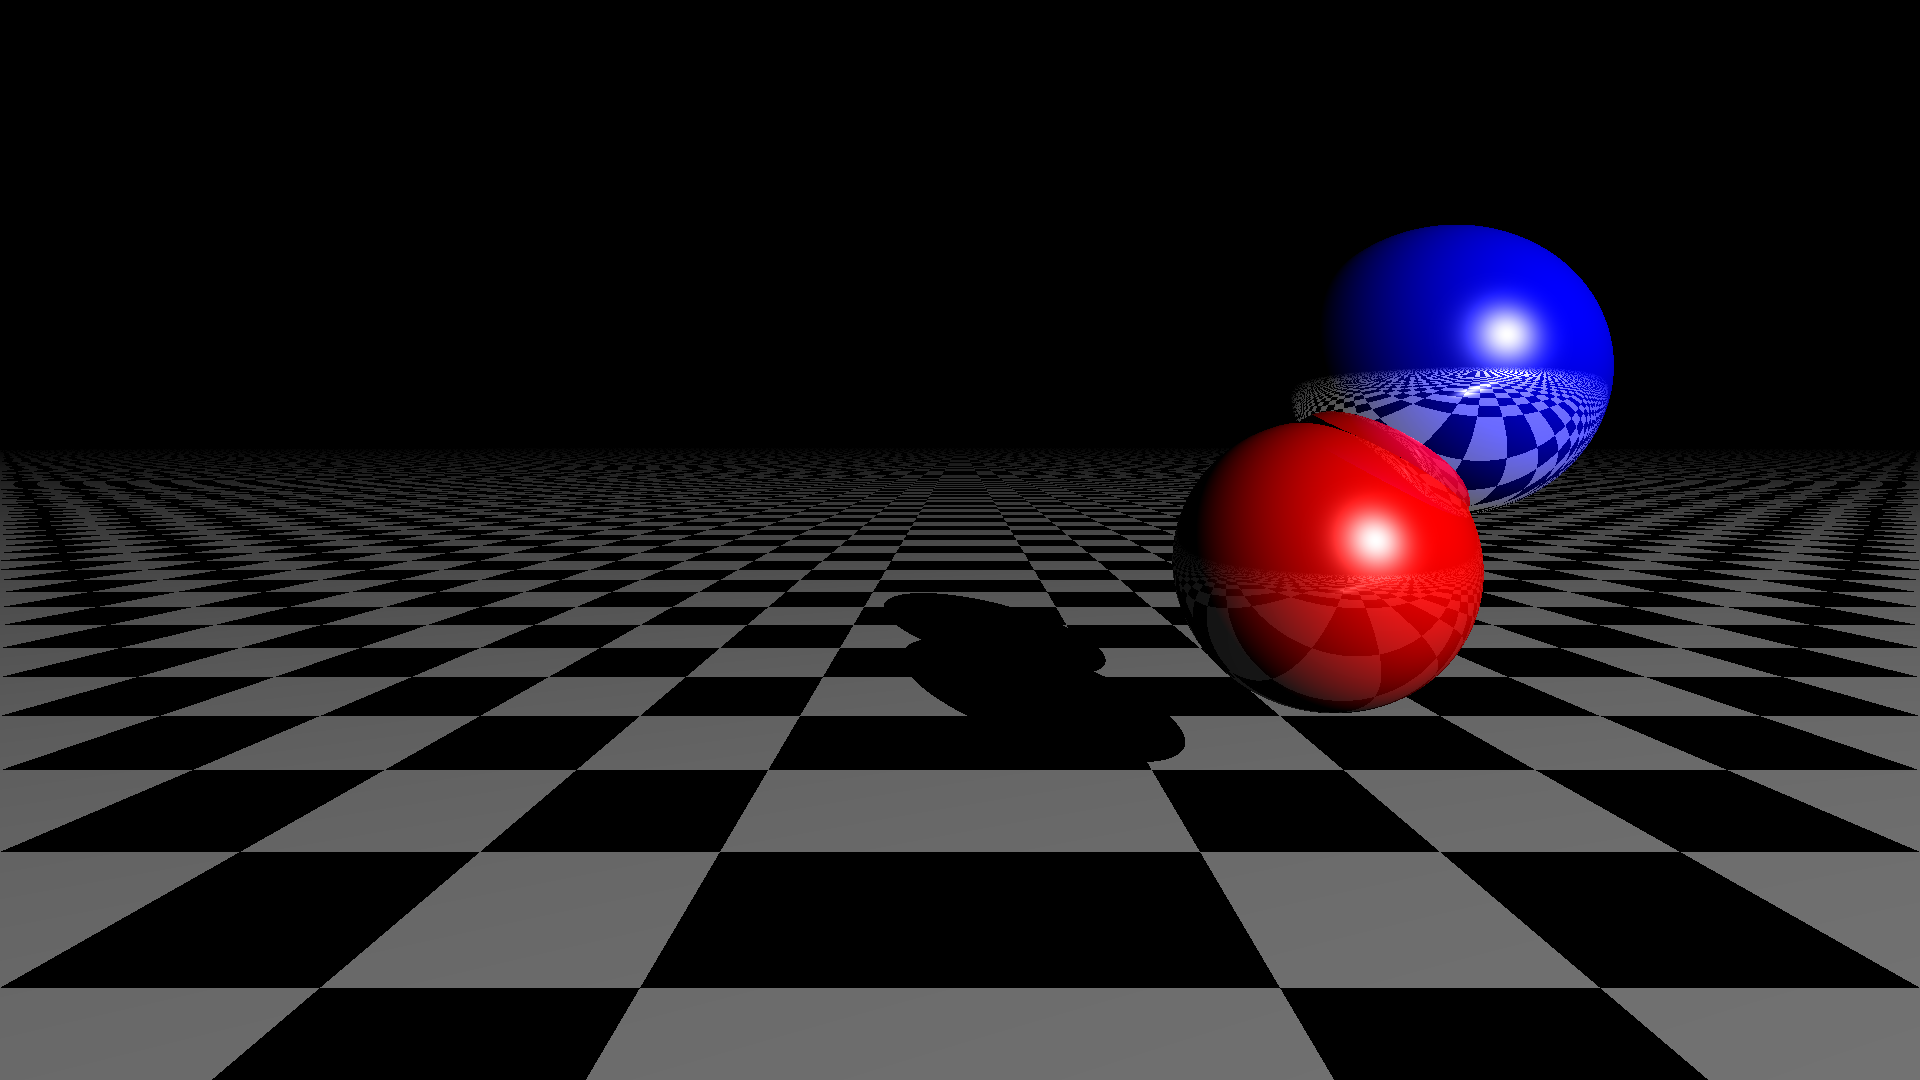

In [ ]:
from IPython.display import display
display(Image.open(file_name))